In [1]:
import sys
import pandas as pd
import numpy as np
import tensorflow as tf
from recommenders.datasets.python_splitters import python_stratified_split
from recommenders.utils.python_utils import get_top_k_scored_items
from recommenders.evaluation.python_evaluation import (
    map_at_k,
    ndcg_at_k,
    precision_at_k,
    recall_at_k,
    rmse,
    mae,
    logloss,
    rsquared,
    exp_var,
    auc,
    confusion_matrix
)
from recommenders.utils.timer import Timer
from recommenders.utils.python_utils import binarize
from sklearn.preprocessing import minmax_scale
# from pandas import *

In [28]:
def load_df(size="1"):
  if(size==5):
    df = pd.read_csv(f"./drive/MyDrive/netflix dataset/combined_data_1.txt",header = None, names = ['userID', 'rating'], usecols = [0,1])
    for i in range(2,5):
      df_temp = pd.read_csv(f"./drive/MyDrive/netflix dataset/combined_data_{i}.txt",header = None, names = ['userID', 'rating'], usecols = [0,1])
      df.append(df_temp)
  else:
    df = pd.read_csv(f"./drive/MyDrive/netflix dataset/combined_data_{size}.txt",header = None, names = ['userID', 'rating'], usecols = [0,1])
  df.index = np.arange(0,len(df))
  df_nan = pd.DataFrame(pd.isnull(df.rating))
  df_nan = df_nan[df_nan['rating'] == True]
  df_nan = df_nan.reset_index()
  movie_np = []
  movie_id = 1
  for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
      temp = np.full((1,i-j-1), movie_id)
      movie_np = np.append(movie_np, temp)
      movie_id += 1
  last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
  movie_np = np.append(movie_np, last_record)
  df = df[pd.notnull(df['rating'])]
  df['itemID'] = movie_np.astype(int)
  df['userID'] = df['userID'].astype(int)
  df['rating'] = df['rating'].astype(float)
  df = df[df["itemID"]]<=15000
  df = df[df["userID"]]<=500000
  return df

In [29]:
df = load_df()

In [4]:
df.shape

(4556371, 3)

In [27]:
index2item = dict(enumerate(df['itemID'].unique()))
index2user = dict(enumerate(df['userID'].unique()))
item2index = {v: k for k, v in index2item.items()}
user2index = {v: k for k, v in index2user.items()}
df['itemID'] = df.itemID.apply(lambda i : item2index[i])
df['userID'] = df.userID.apply(lambda u : user2index[u])

In [30]:
train, test = python_stratified_split(df, ratio=0.75, col_user='userID', col_item='itemID', seed=42)
test = test[test["userID"].isin(train["userID"].unique())]
test = test[test["itemID"].isin(train["itemID"].unique())]

In [7]:
del df

In [8]:
# print(df.head(10))
X = train.pivot_table(index=["userID"], columns=["itemID"], values="rating").fillna(0)
# n_user, n_item = X.shape
# n_feature = 3
# beta = np.random.randn(n_user)
# gamma = np.random.randn(n_item)
# lambdaa = 0.5
# U = np.random.randn(n_user, n_feature)
# V = np.random.randn(n_item, n_feature)
# print(X.head(10))
X = X.to_numpy()

In [9]:
# Create input function directly from numpy array.
R_u, R_i = X.nonzero()
R_s = X[X.nonzero()]
train_data = tf.data.Dataset.from_tensor_slices(
  ({"user": R_u, "item": R_i}, R_s))
train_data = train_data.shuffle(buffer_size=1000).repeat(count=None).batch(1)

# Build the factorization network.
class KerasMF:
  def __init__(self, R, k=3, l2=1e-4, with_bias=False):
    self.l2_reg = tf.keras.regularizers.l2(l2)
    self.m, self.n = R.shape
    self.k = k
    self.with_bias = with_bias
    self.model = self.create_model()

  def create_model(self):
    user_inputs = tf.keras.layers.Input(shape=(1,), name="user")
    item_inputs = tf.keras.layers.Input(shape=(1,), name="item")
    user_embeddings = tf.keras.layers.Embedding(
      input_dim=self.m, output_dim=self.k, name="user_embedding",
      embeddings_regularizer=self.l2_reg)(user_inputs)
    item_embeddings = tf.keras.layers.Embedding(
      input_dim=self.n, output_dim=self.k, name="item_embedding",
      embeddings_regularizer=self.l2_reg)(item_inputs)
    dots = tf.keras.layers.Dot(axes=-1, name="logits")([user_embeddings, item_embeddings])
    if self.with_bias:
      # The formal use of bias need a tf.keras.layers.Dense layer.
      # But since we are customizing our network architecture,
      # we will use the tf.keras.layers.Embedding layer to do the trick.
      user_biases = tf.keras.layers.Embedding(
        input_dim=self.m, output_dim=1, name="user_bias")(user_inputs)
      item_biases = tf.keras.layers.Embedding(
        input_dim=self.n, output_dim=1, name="item_bias")(item_inputs)
      dots = tf.keras.layers.Add()([dots, user_biases, item_biases])
    model = tf.keras.Model(
      name="matrix_factorizer",
      inputs=[user_inputs, item_inputs], outputs=dots)
    model.compile(
      optimizer=tf.keras.optimizers.SGD(),
      loss=tf.keras.losses.MeanSquaredError(),
      metrics=[
        tf.keras.metrics.MeanSquaredError()
      ]
    )
    print(model.summary())
    return model

  def predict_matrix(self):
    keras_user_embeddings = keras_mf.model.get_layer(name="user_embedding").weights[0].numpy()
    keras_item_embeddings = keras_mf.model.get_layer(name="item_embedding").weights[0].numpy()
    keras_user_biases = keras_mf.model.get_layer(name="user_bias").weights[0].numpy()
    keras_item_biases = keras_mf.model.get_layer(name="item_bias").weights[0].numpy()
    dots = keras_user_embeddings.dot(keras_item_embeddings.T)
    dots += keras_user_biases
    dots += keras_item_biases[:,-1]
    dots = np.round(dots, 2)
    return dots
  
  def score(self,test):
    # get user / item indices from test set
    dots = self.predict_matrix()
    user_ids = list(test['userID'].unique())
    
    test_scores = dots[user_ids]

    return test_scores

  def recommend_k_items(self, test, top_k=10, sort_top_k=True):
    test_scores = self.score(test)

    top_items, top_scores = get_top_k_scored_items(
        scores=test_scores, top_k=top_k, sort_top_k=sort_top_k
    )

    df = pd.DataFrame(
        {
            'userID': np.repeat(
                test['userID'].drop_duplicates().values, top_items.shape[1]
            ),
            'itemID': [item for item in top_items.flatten()],
            'prediction': top_scores.flatten(),
        }
    )

    # drop invalid items
    return df.replace(-np.inf, np.nan).dropna()

keras_mf = KerasMF(R=X, with_bias=True)

Model: "matrix_factorizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 item (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 3)         267870      ['user[0][0]']                   
                                                                                                  
 item_embedding (Embedding)     (None, 1, 3)         13497       ['item[0][0]']                   
                                                                                  

In [10]:
del train

In [11]:
keras_mf.model.fit(train_data, epochs=10, steps_per_epoch=100, verbose=1)

Epoch 1/10
100/100 [==============================] - 0s 2ms/step - loss: 8.0745 - mean_squared_error: 8.0511
Epoch 2/10
100/100 [==============================] - 0s 2ms/step - loss: 4.7537 - mean_squared_error: 4.7303
Epoch 3/10
100/100 [==============================] - 0s 1ms/step - loss: 4.6617 - mean_squared_error: 4.6383
Epoch 4/10
100/100 [==============================] - 0s 1ms/step - loss: 3.3393 - mean_squared_error: 3.3160
Epoch 5/10
100/100 [==============================] - 0s 1ms/step - loss: 3.9729 - mean_squared_error: 3.9495
Epoch 6/10
100/100 [==============================] - 0s 1ms/step - loss: 4.4776 - mean_squared_error: 4.4542
Epoch 7/10
100/100 [==============================] - 0s 1ms/step - loss: 3.4935 - mean_squared_error: 3.4701
Epoch 8/10
100/100 [==============================] - 0s 1ms/step - loss: 4.7838 - mean_squared_error: 4.7605
Epoch 9/10
100/100 [==============================] - 0s 1ms/step - loss: 3.4509 - mean_squared_error: 3.4276
Epoch 10/1

In [12]:
with Timer() as test_time:
    top_k = keras_mf.recommend_k_items(test, top_k=10)

print("Took {} seconds for prediction.".format(test_time.interval))

Took 7.013309500000005 seconds for prediction.


In [13]:
top_k.head()

,userID,itemID,prediction
0,0,298,3.74
1,0,3961,3.74
2,0,1083,3.73
3,0,2451,3.72
4,0,4355,3.71


In [14]:
TOP_K=10
eval_map = map_at_k(test, top_k, col_user='userID', col_item='itemID', col_rating='rating', k=TOP_K)
eval_ndcg = ndcg_at_k(test, top_k, col_user='userID', col_item='itemID', col_rating='rating', k=TOP_K)
eval_precision = precision_at_k(test, top_k, col_user='userID', col_item='itemID', col_rating='rating', k=TOP_K)
eval_recall = recall_at_k(test, top_k, col_user='userID', col_item='itemID', col_rating='rating', k=TOP_K)
eval_rmse = rmse(test, top_k, col_user='userID', col_item='itemID', col_rating='rating')
eval_mae = mae(test, top_k, col_user='userID', col_item='itemID', col_rating='rating')
eval_rsquared = rsquared(test, top_k, col_user='userID', col_item='itemID', col_rating='rating')
eval_exp_var = exp_var(test, top_k, col_user='userID', col_item='itemID', col_rating='rating')
# eval_auc = auc(test, top_k, col_user='userID', col_item='itemID', col_rating='rating')
positivity_threshold = 2
test_bin = test.copy()
test_bin['rating'] = binarize(test_bin['rating'], positivity_threshold)

top_k_prob = top_k.copy()
top_k_prob['prediction'] = minmax_scale(
    top_k_prob['prediction'].astype(float)
)

eval_logloss = logloss(test_bin, top_k_prob, col_user='userID', col_item='itemID', col_rating='rating')
print("Model:\t",
      "Top K:\t%d" % TOP_K,
      "MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall,
      "RMSE:\t%f" %eval_rmse,
      "MAE:\t%f" %eval_mae,
      "RSquared:\t%f" %eval_rsquared,
      "Exp_Var:\t%f" %eval_exp_var,
      "Logloss:\t%f" % eval_logloss,
      sep='\n')

Model:	
Top K:	10
MAP:	0.015959
NDCG:	0.064235
Precision@K:	0.055070
Recall@K:	0.049162
RMSE:	3.853898
MAE:	3.724409
RSquared:	-14.065317
Exp_Var:	0.003896
Logloss:	3.443325


In [15]:
from tqdm import tqdm

In [3]:
# %%time

conf_mat = confusion_matrix(keras_mf,test,"HMF")

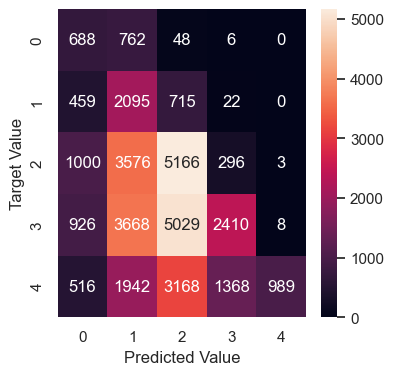

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(4,4)})
sns.heatmap(conf_mat,fmt='',annot=True)
plt.xlabel("Predicted Value")
plt.ylabel("Target Value")
plt.show()